# Statistical Arbitrage: Pairs Trading Strategy Development

In this notebook, we will develop and backtest a pairs trading strategy using US stocks. The process will involve the following steps:

1. **Stock Selection**: We begin by identifying a population of the top 500 US stocks based on highest trading volume.
2. **Data Extraction**: Hourly price data for these stocks will be collected, starting from 2021.
3. **Industry Partitioning**: The selected stocks will be grouped by industry based on their SIC codes.
4. **Cointegration Testing**: For each industry group, we will test pairs of stocks for cointegration, accounting for multiple comparisons bias using the Benjamini-Hochberg process.
5. **Stationarity Testing**: For the identified cointegrated pairs, we will perform ordinary least squares (OLS) regression and use the Augmented Dickey-Fuller test to confirm stationarity, again controlling for multiple comparisons bias.
6. **Selection of Pairs**: From the pairs that pass the stationarity test, we will calculate rolling betas and z-scores, and visualize the price series and z-scores. We will then narrow down the pairs to the top 5 based on the shortest mean reversion half-life, determined using the Ornstein-Uhlenbeck process.
7. **Signal Generation**: Trading signals will be generated when the rolling z-score crosses the ±3 threshold. Positions will be closed when the z-score crosses zero, with an additional 20% stop loss rule in place.
8. **Position Sizing**: Each trade will allocate 20% of the portfolio’s value to the selected pair.
9. **Backtesting**: Finally, we will backtest the strategy using out-of-sample data, achieving a Sharpe ratio of 0.3 and a 6-month return of 120%. Over this period, 27 trades were executed, with 16 profitable trades.


We begin by establishing a connection to the Polygon.io API and iterating through all US exchanges to extract stock tickers along with their corresponding SIC codes. Tickers that have a `None` value for the SIC code, which typically correspond to ETFs, are excluded from this analysis.

In this section of the notebook, we begin by setting up the connection to the Polygon API using an API key. The goal is to gather a list of stock tickers traded on US exchanges, along with their corresponding Standard Industry Classification (SIC) codes.

We first fetch the list of exchanges that handle US stocks through the API, then clean the data by removing any duplicate exchange identifiers (MICs) and any None values.

Next, we loop through each exchange, retrieving the tickers listed on each one. For each ticker, we attempt to fetch its SIC code. Only tickers with a valid SIC code are added to our list. If any errors occur (for example, if a SIC code is missing), they are ignored, and the process continues.

Finally, we compile the valid tickers and their SIC codes into a DataFrame and remove any duplicate entries to ensure a clean list. This data is then saved for further use in the analysis.

In [ ]:
from polygon import RESTClient
import pandas as pd

# Initialize the client with your Polygon API key
api_key = "YOUR_API_KEY_HERE"
client = RESTClient(api_key)

# Fetch exchanges for US stocks
exchanges = pd.DataFrame(client.get_exchanges(asset_class='stocks', locale='us'))  

# Remove duplicates and None from exchange list
exchange_list = list(set(exchanges.mic))  # Get unique exchanges
exchange_list.remove(None)  # Remove None values

us_tickers = []  # List to store valid tickers and SIC codes
for exchange in exchange_list:
    for ticker in client.list_tickers(market='stocks', exchange=exchange):  # Loop through tickers per exchange
        try:
            sic_code = client.get_ticker_details(ticker.ticker).sic_code  # Get SIC code for ticker
            if sic_code is not None:  # Only keep tickers with SIC code
                us_tickers.append([ticker.ticker, sic_code])
        except:
            continue  # Skip errors (e.g., missing details)

# Final ticker list
ticker_list = pd.DataFrame(us_tickers, columns=['Ticker', 'SIC Code']).drop_duplicates()  # Remove duplicates
ticker_list.to_csv('ticker_list.csv')  # Save to CSV
ticker_list.head()  # Display top rows


,Ticker,SIC Code
0,AAAU,6221
1,ARKB,6221
2,BLKC,6282
3,BTCO,6221
4,BTCW,6221


In this section of the notebook, we focus on retrieving and processing the volume data for each ticker over a specified time period, with the aim of identifying the top 500 tickers by trading volume.

We begin by defining the date range for which we want to gather volume data. The start date is set to January 4, 2021, and the end date is set to the previous day. We ensure that the tickers selected have been actively trading since at least January 4, 2021, by skipping those that do not have data for this start date.

For each ticker in our list, we request the daily trading volume data from the Polygon API. If a ticker has no data for the start date, it is excluded from the analysis. We then append the volume data to a list, retaining only the relevant columns (ticker and volume).

Once we have gathered the volume data for all tickers, we combine it into a single DataFrame. This data is then sorted in descending order based on volume, and the top 500 tickers are selected. We merge the filtered list with the original ticker list to include additional information, such as the SIC code, and save both the volume rankings and the top 500 tickers to CSV files for further analysis.

The period from 2021 to 2023 will be used for research, while January to June 2024 will serve as the out-of-sample backtest period.

In [ ]:
from datetime import datetime, timedelta
today = datetime.today()  # Get today's date
start_date = pd.to_datetime('2021-01-04')  # Start date for volume data
start = start_date.strftime('%Y-%m-%d')
end_date = today - timedelta(days=1)  # End date (previous day)
end = end_date.strftime('%Y-%m-%d')
days = (pd.to_datetime(end).date() - pd.to_datetime(start).date()).days + 1  # Calculate total days
volume_data_frames = []  # List to store volume data for tickers

# Fetch volume data for each ticker
for ticker in ticker_list['Ticker'].to_list():
    data_request_1 = client.get_aggs(ticker=ticker, multiplier=1, timespan='day', from_=start, to=start)  # Get data for start date
    if len(pd.DataFrame(data_request_1)) == 0:  # Skip tickers with no data
        continue
    data_request_2 = client.get_aggs(ticker=ticker, multiplier=days, timespan='day', from_=start, to=end)  # Get data for full period
    volume_data = pd.DataFrame(data_request_2)  # Convert to DataFrame
    volume_data['Ticker'] = ticker  # Add Ticker column
    volume_data = volume_data[['Ticker', 'volume']]  # Keep only relevant columns
    volume_data_frames.append(volume_data)  # Append data to list

# Concatenate all volume data, sort by volume, and select top 500
volume_rankings = pd.concat(volume_data_frames, ignore_index=True).sort_values(by='volume', ascending=False)
in_scope_tickers = volume_rankings.head(500)  # Get top 500 tickers by volume
in_scope_tickers = in_scope_tickers.merge(ticker_list, on='Ticker')  # Merge with original ticker list for full info
volume_rankings.to_csv('volume_rankings.csv')  # Save volume rankings to CSV
in_scope_tickers.to_csv('in_scope_tickers.csv')  # Save top 500 tickers to CSV
in_scope_tickers.head(5)


,Ticker,volume,SIC Code
0,NVDA,4.358517e+11,3674
1,TSLA,9.890466e+10,3711
2,AAPL,7.276331e+10,3571
3,F,6.521758e+10,3711
4,AMD,6.382222e+10,3674


In this section, we enhance the `in_scope_tickers` list by adding industry classifications based on SIC codes. We load a CSV containing SIC codes and their associated industries, which can be found at:
[ SIC Code List](https://www.sec.gov/search-filings/standard-industrial-classification-sic-code-list). 

The SIC Code column is merged with `in_scope_ticker`s to include industry information.

The 'Office' represents the SIC code, while 'Industry Title' indicates the corresponding industry classification. The resulting DataFrame, `in_scope_tickers_with_industry`, now includes tickers with their SIC codes and industries.

In [ ]:
sic_code_industries = pd.read_csv('SIC Codes.csv')
sic_code_industries['SIC Code'] = sic_code_industries['SIC Code'].astype(str)
in_scope_tickers['SIC Code'] = in_scope_tickers['SIC Code'].astype(str)
in_scope_tickers_with_industry = in_scope_tickers.merge(sic_code_industries, on='SIC Code')
in_scope_tickers_with_industry.head(5)

,Ticker,volume,SIC Code,Office,Industry Title
0,NVDA,4.358517e+11,3674,Office of Manufacturing,SEMICONDUCTORS & RELATED DEVICES
1,TSLA,9.890466e+10,3711,Office of Manufacturing,MOTOR VEHICLES & PASSENGER CAR BODIES
2,AAPL,7.276331e+10,3571,Office of Technology,ELECTRONIC COMPUTERS
3,F,6.521758e+10,3711,Office of Manufacturing,MOTOR VEHICLES & PASSENGER CAR BODIES
4,AMD,6.382222e+10,3674,Office of Manufacturing,SEMICONDUCTORS & RELATED DEVICES


**Date Partitions:** We create a list of date ranges, each spanning 6 months, starting from 4th January 2021 and continuing until the end date. These partitions allow us to efficiently retrieve the data in smaller chunks that fit within the API's constraints.

**Industry Data Processing:** We create a list of unique industries based on the SIC codes of the in-scope tickers. For each industry, we:
- Retrieve hourly data for each ticker within that industry, across each 6-month partition.
- If data is available, we extract the timestamp and volume-weighted average price (VWAP) for each hour.
- We convert the timestamp to Eastern Time and keep the relevant columns, such as the VWAP and Ticker.

**Data Aggregation:** For each industry, we concatenate the hourly data for all tickers and pivot the data so that the tickers become columns, with timestamps as the index. We also forward-fill and backfill any missing data to ensure continuity in the dataset.

In [19]:
date_partitions = []  # Store 6-month date partitions
current_start = start_date
while current_start < end_date:
    current_end = min(current_start + timedelta(days=183), end_date)  # Define partition end
    date_partitions.append([current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d')])  # Append partition
    current_start = current_end + timedelta(days=1)  # Move to next start date

industries = list(set(in_scope_tickers_with_industry['Office'].to_list()))  # List of industries
industry_dataframes = {}  # Dictionary for industry dataframes

for industry in industries:
    hourly_price_dfs = []  # List to hold hourly data for this industry
    indsustry_tickers = in_scope_tickers_with_industry.loc[in_scope_tickers_with_industry['Office'] == industry, 'Ticker'].to_list()  # Get tickers for the industry
    
    # Fetch data for each ticker and partition
    for ticker in indsustry_tickers:
        for partition in date_partitions:
            data_request = client.get_aggs(ticker=ticker, timespan='hour', multiplier=1, from_=partition[0], to=partition[1], limit=50000)  # API call for data
            hour_df = pd.DataFrame(data_request)
            
            if len(hour_df) > 0:  # Check if data exists
                hour_df['timestamp'] = pd.to_datetime(hour_df['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')  # Convert timestamp
                hour_df = hour_df[['timestamp', 'vwap']]  # Select relevant columns
                hour_df['Ticker'] = ticker  # Add Ticker column

                hourly_price_dfs.append(hour_df)  # Append the data for this ticker

    # Concatenate data and pivot by Ticker
    industry_dataframe = pd.concat(hourly_price_dfs, ignore_index=True).sort_values(by='timestamp', ascending=True)
    industry_dataframe_pivot = industry_dataframe.pivot(index='timestamp', columns='Ticker', values='vwap')  # Pivot dataframe
    industry_dataframe_pivot = industry_dataframe_pivot.ffill()  # Forward fill missing values
    industry_dataframe_pivot = industry_dataframe_pivot.bfill()  # Backfill missing values
    industry_dataframe_pivot.to_csv(f'{industry}.csv')  # Save to CSV
    industry_dataframes[industry] = industry_dataframe_pivot  # Store in industry dictionary

Now that we have gathered the relevant price data for each of our securities, partitioned by industry, we can begin the process of identifying pairs to trade and determining the strategy to employ. The first question we need to answer is: *how do we identify pairs that are suitable for a Long/Short or Pairs Trading strategy?* To address this, we first need to introduce a couple of key mathematical concepts: *stationarity* and *cointegration*.

###*Stationarity

A time series is said to be *stationary* if its statistical properties, such as mean, variance, and autocorrelation, are constant over time. In other words, the process does not exhibit trends or cycles that cause the data to change over time. Stationarity is a crucial property in financial time series analysis because many statistical methods, including those used in pairs trading, assume stationarity.

Mathematically, a time series $ y_t $ is stationary if:

- $ E[y_t] = \mu $ (the mean is constant),
- $ Var(y_t) = \sigma^2 $ (the variance is constant),
- $ Cov(y_t, y_{t+k}) = \gamma_k $ (the autocovariance function depends only on the lag $ k $ and not on time $ t $).

If a time series is *non-stationary*, it may have trends or seasonality, and its statistical properties may change over time. This could lead to misleading results in statistical models. In the context of pairs trading, stationarity helps us ensure that the relationship between the two assets we are analysing remains stable over time, which is crucial for making profitable trades.

### Cointegration

Now that we have the concept of stationarity, we can discuss *cointegration*, which is a key concept when it comes to identifying pairs that move together over time. While stationarity ensures that a time series is stable, cointegration goes a step further to determine whether two non-stationary time series have a stable long-term relationship.

Two time series, $ y_t$  and $ x_t $, are said to be *cointegrated* if there exists a linear combination of them that is stationary. In other words, even if $ y_t $ and $ x_t $ themselves are non-stationary, their combination may form a stationary series. This implies that the two series share a long-term equilibrium relationship, which is crucial for pairs trading.

Mathematically, $ y_t $ and $ x_t $ are cointegrated if there exists some constant $ \beta $ such that the series:

$$  z_t = y_t - \beta x_t  $$

is stationary. Here, $ z_t $ is the residual or spread between the two series, and $ \beta $ is the cointegration coefficient. If this residual series $ z_t $ is stationary, then the two time series are cointegrated.

### Cointegration and Pairs Trading

In pairs trading, we seek to identify two assets whose price movements are highly correlated in the long term. When two assets are cointegrated, it means that their prices move together in a predictable manner, even though they might drift apart temporarily. This gives us the opportunity to trade the divergence and convergence of the two prices.

For instance, if two stocks are cointegrated and their price spread diverges beyond a certain threshold, we might go long on the underperforming stock and short on the outperforming one, betting that the spread will eventually return to its equilibrium value.

By applying tests for stationarity and cointegration, we can identify pairs of stocks that have stable, long-term relationships. These pairs are ideal candidates for pairs trading strategies, where the assumption is that the relationship between the stocks will hold over time, allowing us to profit from short-term divergences.

In the code below, we will be testing for stationarity across all possible pairs within each industry. We will not be testing for pairs across different industries, as we want to focus on pairs where there is a logical basis for potential cointegration, and also to reduce the number of comparisons we need to make. Specifically, we will be using the `coint` function from the `**`statsmodels.tsa.stattools`**` module.

The `coint` function tests whether two time series are cointegrated, which means they share a long-term, stable relationship despite being non-stationary individually. The test returns a cointegration test statistic, a p-value, and critical values for different significance levels. The default method used by the `coint` function is the *Engle-Granger two-step cointegration test*, which was first introduced by Robert Engle and Clive Granger in 1987. The method consists of the following steps:

However, before proceeding with the stationarity tests, we need to address the issue of *Multiple Comparisons Bias*.

### Multiple Comparisons Bias

Multiple comparisons bias, (also known as multiple testing problem), arises when we perform a large number of statistical tests simultaneously. When we test many hypotheses, the likelihood of incorrectly rejecting a null hypothesis (i.e., committing a Type I error) increases, even if none of the tests have a true effect. 

For example, if we conduct 100 independent hypothesis tests, and we use a standard significance level of 0.05 (which means there's a 5% chance of incorrectly rejecting the null hypothesis), we expect to incorrectly reject the null hypothesis about 5 times out of 100, even if the null hypothesis is true in all cases. The more tests we perform, the greater the chance of obtaining false positives—incorrectly concluding that a relationship exists when it does not. This is particularly problematic when making multiple pairwise comparisons, as we might falsely identify cointegration in pairs purely due to random chance.

The impact of multiple comparisons bias can be substantial, especially when dealing with a large number of asset pairs, such as in our case, where we're testing many combinations of securities within an industry. As such, it is essential to account for this bias to avoid misleading results.

### The Benjamini-Hochberg Procedure

To mitigate the risk of multiple comparisons bias, we will apply the *Benjamini-Hochberg procedure*, a method designed to control the *False Discovery Rate (FDR)*. The FDR is the proportion of false positives among the significant results. Unlike traditional methods that control the family-wise error rate (which keeps the probability of any false positive at a low level), the Benjamini-Hochberg procedure offers a more flexible approach that allows us to control the proportion of false positives among the rejected hypotheses, making it less conservative while still reducing the chance of errors.

The Benjamini-Hochberg procedure works as follows:

1. **Rank the p-values** from all the individual tests in ascending order.
2. For each test $ i $, calculate a threshold $ \frac{i}{m} \cdot Q $, where:
   - $ i $ is the rank of the p-value,
   - $ m $ is the total number of tests, and
   - $ Q $ is the desired false discovery rate (in our case, $ Q = 0.05 $).
3. **Reject all hypotheses** with p-values less than or equal to the calculated threshold.

This method ensures that we limit the proportion of false discoveries while still allowing for more discoveries than would be possible if we controlled the family-wise error rate strictly. By applying this procedure, we can reduce the impact of multiple comparisons bias and focus on identifying truly significant relationships between asset pairs within the same industry.



In [20]:
def benjamini_hochberg(data, comparisons, alpha=0.05):
    # Sort the data by p-value in ascending order
    data_sorted = sorted(data, key=lambda x: x[3])
    
    # Calculate critical values for each p-value
    critical_values = [(i / comparisons) * alpha for i in range(1, comparisons + 1)]
    
    # Add a flag indicating whether the null hypothesis is rejected
    results = []
    for i, (industry, ticker1, ticker2, p_value) in enumerate(data_sorted):
        critical_value = critical_values[i]
        if not any(ticker1 in (res[1], res[2]) or ticker2 in (res[1], res[2]) for res in results):
            if p_value <= critical_value:
                results.append((industry, ticker1, ticker2, p_value))
    
    return results

In [21]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

def find_cointegrated_pairs(industry_dataframes): 
    cointegrated_pairs = []  # List to store cointegrated pairs
    industry_assets = {}  # Store assets by industry

    for industry, data in industry_dataframes.items():
        data = data[data.index < pd.Timestamp('2024-01-01').tz_localize('UTC')]  # Filter data
        n = data.shape[1]  # Number of assets
        comparisons = int(n*(n-1)/2)  # Number of comparisons
        score_matrix = np.zeros((n, n))  # Initialize score matrix
        pvalue_matrix = np.ones((n, n))  # Initialize p-value matrix
        keys = data.keys()  # Get asset names
        pairs = []

        # Test cointegration for each pair
        for i in range(n):
            for j in range(i+1, n):
                S1, S2 = data[keys[i]], data[keys[j]]
                result = coint(S1, S2, maxlag=1)
                score_matrix[i, j], pvalue_matrix[i, j] = result[0], result[1]
                pairs.append((industry, keys[i], keys[j], result[1]))

        # Apply Benjamini-Hochberg for multiple comparison correction
        for pair in benjamini_hochberg(pairs, comparisons, 0.05):
            cointegrated_pairs.append(pair)  # Add cointegrated pair
            industry_assets.setdefault(industry, []).extend([pair[1], pair[2]])  # Add assets

    return cointegrated_pairs, industry_assets

In [22]:
pairs, industry_assets = find_cointegrated_pairs(industry_dataframes)

print(f'Number of industries = {len(industry_dataframes)}')
print(f'Number of cointegrated pairs identified = {len(pairs)}')

Number of industries = 10
Number of cointegrated pairs identified = 99


Now that we have identified 99 cointegrated securities across our 10 industries, this means that there exists a linear combination of these pairs which is stationary. The next step is to test that we can find such a linear combination and confirm its stationarity. To do this, we will use ordinary least squares (OLS) regression, which is appropriate because it provides the best linear unbiased estimates for the parameters of the linear relationship between the two asset prices.

### **OLS Linear Regression for Beta Estimation**

In the context of cointegration, OLS regression is used to estimate the relationship between the two asset prices, $S_1$ and $S_2$, by fitting a linear model:
$$
S_2 = \alpha + \beta S_1 + \epsilon_t
$$
where $ \beta $ is the coefficient that represents the linear relationship between the two series, and $ \epsilon_t $ is the residual or spread. The value of $ \beta $ is estimated using OLS regression. Once $ \beta $ is determined, we can calculate the *spread* as:
$$
\text{spread}_t = S_2 - \beta S_1
$$
This spread is the difference between the two asset prices, adjusted by their estimated relationship.

### Augmented Dickey-Fuller (ADF) Test for Stationarity

Once we have the spread, we need to test if it is stationary, meaning it does not exhibit a unit root or a time-dependent trend. For this, we use the *Augmented Dickey-Fuller (ADF) test*, which is a statistical test used to check if a time series is non-stationary due to a unit root.

The ADF test is based on the following regression:
$$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \epsilon_t
$$
where:
- $ \Delta y_t $ is the first difference of the series,
- $ \beta t $ is a deterministic trend component,
- $ \gamma y_{t-1} $ represents the autoregressive component,
- $ \delta_i $ are the coefficients for the lagged differences, and
- $ \epsilon_t $ is the error term.

The null hypothesis of the ADF test is that the series has a unit root (i.e., it is non-stationary). If the p-value is less than a predefined significance level (e.g., 0.05), we reject the null hypothesis and conclude that the spread is stationary.

Given that we are testing multiple pairs of assets for stationarity, there is a risk of multiple comparisons bias once again. Therefore, once again we will apply the Benjamini-Hochberg procedure.


In [23]:
from statsmodels.tsa.stattools import adfuller

stationary_test = []
for industry in set([p[0] for p in pairs]):
    df = industry_dataframes[industry][industry_assets[industry]].copy()
    df = df[df.index < pd.Timestamp('2024-01-01').tz_localize('UTC')]  # Filter data for the in-sample period

    # Process each pair in the industry to test for stationarity
    industry_pairs = [[p[1], p[2]] for p in pairs if p[0] == industry]
    for pair in industry_pairs:
        S1, S2 = df[pair[0]], df[pair[1]]  # Extract asset prices
        beta = sm.OLS(S1, S2).fit().params.iloc[0]  # Estimate beta using OLS regression
        full_spread = S2 - beta * S1  # Calculate the spread
        
        # Perform the Augmented Dickey-Fuller test for stationarity
        stationarity = adfuller(full_spread)
        pvalue = stationarity[1]  # Extract the p-value from the test
        if pvalue < 0.05:  # Check if the spread is stationary at the 5% significance level
            stationary_test.append([industry] + pair + [pvalue])

# Account for multiple comparisons bias using the Benjamini-Hochberg procedure
stationary_pairs = benjamini_hochberg(stationary_test, len(pairs), 0.05)

The next section of the code calculates various metrics for generating trading signals. These metrics, such as the rolling beta, spread, and Z-scores, are essential in determining the profitability of potential trades within each industry. Let's break down the process:

1. **Rolling Beta Calculation**: The first step is to calculate the *rolling beta* for each pair of assets. The window size is defined as `30 * 16` periods (30 days * 16 hourly periods per day). This rolling beta is calculated using Ordinary Least Squares regression for each sliding window of asset data. For each window, the relationship between asset prices is captured by the beta coefficient, which is then used to calculate the spread. 
The reason for using a rolling beta, rather than a single static beta for the entire period, is that market conditions can change over time, leading to fluctuations in the relationship between the two assets. A rolling beta recalculates the relationship periodically, accounting for any short-term changes in the correlation between the asset prices.

Even though the spread is stationary over the entire period, the rolling beta allows us to capture the evolving dynamics between the two assets, especially in high-frequency data like hourly prices. This ensures that the spread is calculated in a way that reflects current market conditions.

2. **Spread Calculation**: The spread for each pair is calculated as:
   $$
   \text{Spread} = S_2 - \beta \cdot S_1
   $$
   where $ S_1 $ and $ S_2 $ are the prices of the two assets in the pair, and $ \beta $ is the rolling beta. This spread measures the relative price difference between the two assets, adjusted for their historical correlation.

3. **Z-Scores**: Once the spread is calculated, the Z-score is computed to standardize the spread. The Z-score measures how far the spread is from its historical mean in terms of standard deviations. This is crucial because it allows us to identify extreme deviations from the mean, which may indicate potential trading opportunities. The Z-score is calculated as:
   $$
   \text{Z-Score} = \frac{\text{Spread}_{\text{mavg1}} - \text{Spread}_{\text{mavg30}}}{\text{std}_{30}}
   $$
   where:
   - $ \text{Spread}_{\text{mavg1}} $ is the 1-period moving average of the spread.
   - $ \text{Spread}_{\text{mavg30}} $ is the 30-period moving average of the spread.
   - $ \text{std}_{30} $ is the 30-period rolling standard deviation of the spread.

   The Z-score allows us to identify when the spread is unusually high or low, which could signal potential buy or sell opportunities. A high positive Z-score indicates the spread is wide, and a low or negative Z-score indicates the spread is narrow, potentially reversing.

4. **Value Traded in Spread**: Finally, we calculate the **value traded in the spread**, which is the total notional value of the assets being traded. This is determined by:
   $$
   \text{Value Traded in Spread} = |S_2| + |\beta \cdot S_1|
   $$

   This metric helps assess the amount of capital involved in each trade.

In [24]:
trading_dataframes = {}
window = 30 * 16  # Define rolling window size (30 days * 16 periods per day)

for industry in set([p[0] for p in stationary_pairs]):  
    df = industry_dataframes[industry][industry_assets[industry]].copy()    
    industry_pairs = [[p[1], p[2]] for p in stationary_pairs if p[0] == industry]
    
    # Process each pair in the industry to calculate trading metrics
    for pair in industry_pairs:
        S1, S2 = df[pair[0]], df[pair[1]]  # Extract asset prices

        # Calculate rolling beta using OLS regression
        rolling_beta = [np.nan] * window
        for n in range(window, len(S1)):
            y, X = S1[(n - window):n], S2[(n - window):n]
            rolling_beta.append(sm.OLS(y, X).fit().params.iloc[0])
        rolling_beta = pd.Series(rolling_beta, index=S2.index)
        
        # Calculate spread, z-scores, and value traded in spread
        spread = S2 - rolling_beta * S1
        spread_mavg1 = spread.rolling(window=1).mean()
        spread_mavg30 = spread.rolling(window).mean()
        std_30 = spread.rolling(window).std()
        zscore_30_1 = (spread_mavg1 - spread_mavg30) / std_30
        value_traded_in_spread = abs(S2) + abs(rolling_beta * S1)
        
        # Store calculated metrics in the DataFrame
        df.loc[:, pair[0] + '_' + pair[1] + '_Spread'] = spread
        df.loc[:, pair[0] + '_' + pair[1] + '_Beta'] = rolling_beta
        df.loc[:, pair[0] + '_' + pair[1] + '_zScore'] = zscore_30_1
        df.loc[:, pair[0] + '_' + pair[1] + '_ValueTraded'] = value_traded_in_spread
    
    trading_dataframes[industry] = df  # Save updated DataFrame for the industry

In this section, we are plotting the prices of the stationary asset pairs identified earlier, along with their corresponding Z-scores. For each pair, we create a subplot displaying the asset prices in blue and orange, and the Z-scores in red. The plots are organized by industry, and the Z-scores are visualized for every second pair. This allows us to visually analyze the asset prices alongside their normalized spread, helping to identify any significant deviations or potential trading signals.

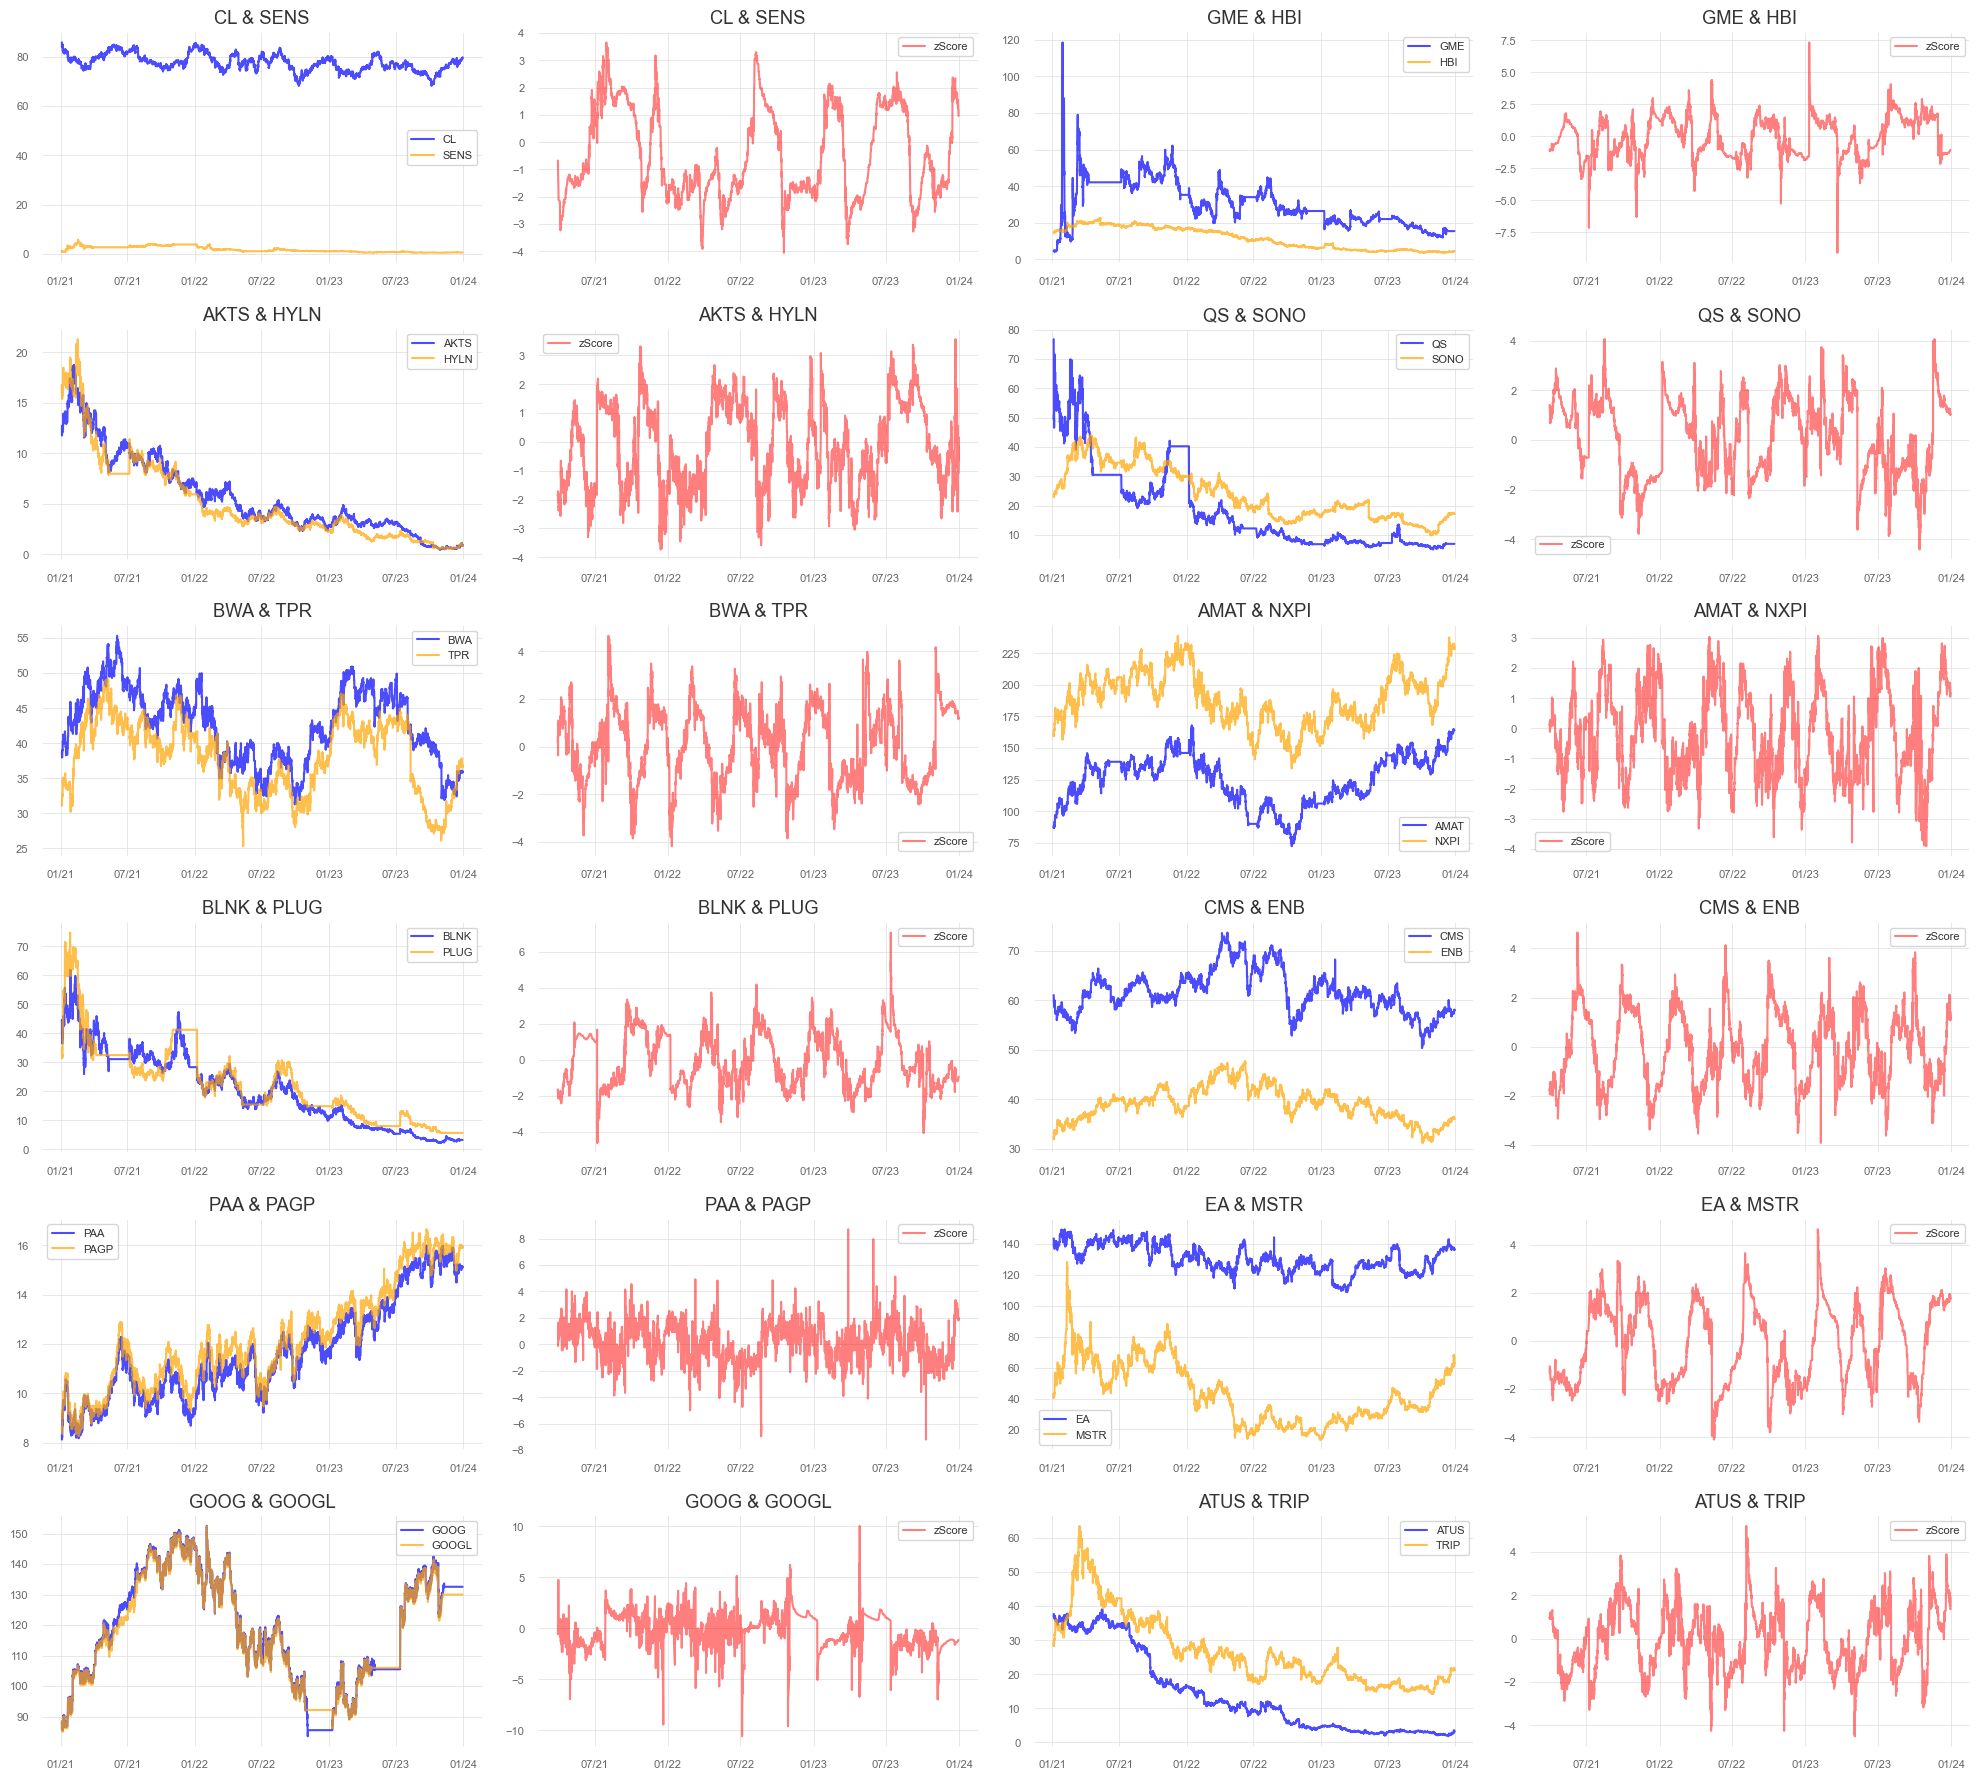

In [25]:
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates

# Initialize an empty list to store all the column pairs
all_column_pairs = []

# Loop through each dataframe in trading_dataframes
for industry, plot_data in trading_dataframes.items():
    # Extract column pairs for the current dataframe
    column_pairs = [[industry] + [p[1],p[2]] for p in stationary_pairs if p[0] == industry]
    for p in column_pairs:
        all_column_pairs.append(p)
        all_column_pairs.append(p)

#Calculate the number of rows needed for the subplot grid
num_rows = math.ceil(len(all_column_pairs) / 4)

# # Create the subplots (5 columns, enough rows to accommodate all pairs)
fig, axes = plt.subplots(num_rows, 4, figsize=(20, 3 * num_rows))

# # Flatten the axes array to make it easier to loop through
axes = axes.flatten()

#Loop through each subplot and column pair
for i, (ax, (industry, col1, col2)) in enumerate(zip(axes, all_column_pairs)):
    data = trading_dataframes[industry]
    data = data[data.index < pd.Timestamp('2024-01-01').tz_localize('UTC')] 
    if i % 2 == 0:
        ax.plot(data.index, data[col1], label=col1, color="blue", alpha=0.7)
        ax.plot(data.index, data[col2], label=col2, color="orange", alpha=0.7)
    else:
        ax.plot(data.index, data[col1 + '_' + col2 + '_zScore'], label='zScore', color="red", alpha=0.5)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%y"))

    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
        

    ax.set_title(f"{col1} & {col2}")
    ax.legend()
    ax.legend(fontsize=8) 

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In this section, we filter the 12 stationary asset pairs down to the 5 pairs with the shortest mean reversion half-life. To do this, we apply the Ornstein-Uhlenbeck process, a common model for mean reversion in financial time series.

The Ornstein-Uhlenbeck process models the mean-reverting behavior of a spread and is governed by the equation:

$$
dX_t = \theta (\mu - X_t) dt + \sigma dW_t
$$

Where:
- $ X_t $ is the value of the spread at time $ t $,
- $ \theta $ is the rate of mean reversion,
- $ \mu $ is the long-term mean (assumed to be zero for simplicity),
- $ \sigma $ is the volatility of the spread,
- $ dW_t $ is the increment of a Wiener process (Brownian motion).

The half-life of mean reversion is the time it takes for the spread to revert to half of its original deviation from the mean. The formula for the half-life $ t_{1/2} $ is derived from the Ornstein-Uhlenbeck process:

$$
t_{1/2} = \frac{\ln(2)}{-\theta}
$$

Where $ \theta $ is the coefficient of the spread from the regression between the difference in spread values and the spread itself.

We compute the half-life for each stationary pair's Z-score using this formula. After calculating the half-life for each pair, we select the top 5 pairs with the shortest mean reversion half-lives.


In [26]:
# Initialize list to store half-life data
half_life_data = []

for industry in trading_dataframes:
    data = trading_dataframes[industry].copy()
    pair_zscores = [column for column in data if '_zScore' in column]
    data = data[data.index < pd.Timestamp('2024-01-01').tz_localize('UTC')]  # Use only in-sample data

    # Calculate half-life for each pair's z-score
    for pair in pair_zscores:
        spread = pd.DataFrame(data[pair]).dropna()  # Get spread data and drop NaNs
        spread[pair + '_Diff'] = spread[pair].diff()

        # Prepare data for regression: y = spread_diff, x = spread
        y = spread[pair + '_Diff'].shift(-1)[:-1]
        x = sm.add_constant(spread[pair][:-1])

        # Fit OLS regression and calculate half-life of mean reversion
        model = sm.OLS(y, x).fit()
        theta = model.params[pair]
        half_life = np.log(2) / -theta
        half_life_data.append([pair[:-7], float(half_life)])

# Convert to DataFrame and select the top 5 pairs with the shortest half-life
half_life_df = pd.DataFrame(half_life_data, columns=['Pair', 'Half Life'])
top_5_pairs = half_life_df.nsmallest(5, 'Half Life')['Pair'].tolist()
top_5_pairs

['PAA_PAGP', 'GOOG_GOOGL', 'AMAT_NXPI', 'AKTS_HYLN', 'BWA_TPR']

### Explanation of Selected Pairs

1. **PAA_PAGP** (Plains All American Pipeline & Plains GP Holdings)
   - PAA and PAGP are closely linked within the energy sector, where PAGP acts as the general partner of PAA. This creates a strong correlation between the two, as they share financial interests and are affected by similar market conditions in the oil and gas industry. Their price movements are typically synchronised, making them a solid choice for pairs trading based on historical price relationships.

2. **GOOG_GOOGL** (Alphabet Inc. Class C & Class A shares)
   - GOOG and GOOGL are both shares of Alphabet Inc., but differ in voting rights. Despite this, their financial performance and price movements are nearly identical. The minimal divergence between the two classes, driven by a small difference in voting privileges, creates a stable spread that can be effectively traded when mispricings occur.

3. **AMAT_NXPI** (Applied Materials & NXP Semiconductors)
   - Both AMAT and NXPI are major players in the semiconductor industry, with AMAT focusing on the equipment and materials side of semiconductor production, while NXPI manufactures semiconductor solutions. Due to their exposure to similar industry trends and market cycles, the spread between these two stocks may be ideal for pairs trading.

4. **AKTS_HYLN** (Akoustis Technologies & Hyliion Holdings)
   - AKTS and HYLN are both involved in emerging technologies within the communication and transportation sectors. While Akoustis develops next-generation filters for wireless communications and Hyliion works on electrification solutions for trucks, both are exposed to similar technological trends. 

5. **BWA_TPR** (BorgWarner & Tapestry)
   - BWA, a leader in automotive components, and TPR, a luxury goods company, are not from the same industry, but both are influenced by global economic factors such as consumer spending, interest rates, and supply chain dynamics.



### Data Preparation and Signal Generation and 
In this section of the code, we combine the individual trading dataframes for each industry into a single, unified dataframe for backtesting. We use `pd.concat` to combine all the industry-specific dataframes along the columns, aligning them by their index. This effectively creates a master dataframe containing all relevant trading data for each of the 5 pairs identified earlier. After concatenating the data, we remove the first level of multi-level column names (industry names) so that we are left with just the pair names, making the dataframe easier to work with.

We filter the data to focus on the 6-month period from January 1, 2024, to June 30, 2024. This period is entirely out-of-sample, as all statistical analysis up to this point used data from 2021 to 2023. This ensures the backtest is performed on unseen data.


For each pair, we initialize a trading signal column (`_Signal`) with default values set to 0. This column will later hold our buy (long) or sell (short) signals.

Trading signals are based on the z-score of the spread between the asset pair. A z-score above 3 signals a short position, while below -3 signals a long position.
- Long Signal: A signal of 1 is triggered when the z-score drops below -3, prompting us to open a long position.
- Short Signal: A signal of -1 is triggered when the z-score rises above +3, prompting us to open a short position.
- Closing Positions: If there is an open position and the z-score crosses 0, the position is closed to lock in profits or prevent further losses.
- Stop Loss: Any position that incurs a 20% loss will trigger a stop loss, closing the position to limit further risk.


In [28]:
# Combine all trading dataframes along columns, aligning indices ('outer' join)
combined_df = pd.concat(trading_dataframes, axis=1, join='outer')

# Drop the first level of multi-level column names, leaving only the relevant names
combined_df.columns = combined_df.columns.droplevel(0)
combined_df = combined_df.loc[:, combined_df.columns[combined_df.columns.str.contains('|'.join(top_5_pairs))]]
combined_df = combined_df.sort_index(ascending=True)

# Forward-fill missing values to handle gaps in data
combined_df = combined_df.ffill()

# Drop any rows that still contain missing values after forward-filling
combined_df = combined_df.dropna()

# Filter data to include only rows (dates) starting from January 1, 2024
combined_df = combined_df[combined_df.index >= pd.Timestamp('2024-01-01').tz_localize('UTC')]

combined_df = combined_df[combined_df.index < pd.Timestamp('2024-07-01').tz_localize('UTC')]

for pair in [c[:-7] for c in combined_df.columns.values if 'Spread' in c]:
    combined_df[pair + '_Signal'] = 0  # Initialize the trading signal column with default value 0

    # Generate trading signals based on z-score thresholds
    combined_df[pair + '_Signal'] = (
        # Long signal: When z-score crosses below -3 (mean-reverting opportunity)
        (combined_df[pair + '_zScore'].shift(1) > -3) &  # Previous z-score was above -3
        (combined_df[pair + '_zScore'] < -3)             # Current z-score is below -3
    ).astype(int) - (
        # Short signal: When z-score crosses above +3 (mean-reverting opportunity)
        (combined_df[pair + '_zScore'].shift(1) < 3) &   # Previous z-score was below 3
        (combined_df[pair + '_zScore'] > 3)             # Current z-score is above 3
    ).astype(int)

combined_df.to_csv('combined_df.csv')


This section of code retrieves the closing price data for the SPDR S&P 500 ETF (SPY) from January 1, 2024, to June 30, 2024, using Yahoo Finance. This data serves as a benchmark for backtesting, allowing us to compare the performance of our pairs trading strategy against the broader market during the same period. The timezone information is removed from the index to ensure compatibility

In [29]:
import yfinance as yf

# Define the start and end dates for data retrieval
start = '2024-01-01'
end = '2024-06-30'

benchmark = 'SPY'  # SPDR S&P 500 ETF used as the benchmark

# Download benchmark data for the specified date range
downloads = yf.download(
    [benchmark],  # Ticker symbol for the benchmark
    start,  # Start date
    end,  # End date
    group_by='ticker',  # Group data by ticker symbol
    progress=False  # Disable progress bar during download
)

# Extract the closing price of the benchmark
benchmark = downloads[benchmark]['Close']

# Remove timezone information from the index for compatibility
benchmark.index = benchmark.index.tz_localize(None)

This section sets up our backtest using the `btester` library's `Strategy` and `Backtest` classes. The `init` function initializes the strategy by storing the spread data, extracting the relevant pair symbols, and tracking the z-scores. The `next` function defines the actions taken at each time step, including opening and closing positions based on trading signals and z-score crossings.

We allocate a maximum position size of 20% of our total portfolio value for each trade, since we are trading 5 pairs (1/5 = 20%). This ensures that each position is appropriately sized relative to our total capital.

In [30]:
from btester import Strategy, Backtest

class Pairs(Strategy):
    # Percentage of available capital to allocate per trade
    buy_at_once_size = .2  # 20%
    
    def init(self, spread_data):
        # Store the spread data and initialize the strategy state
        self.spread_data = spread_data
        
        # Extract stock pair symbols from spread data column names
        self.symbols = [pair[:-7] for pair in spread_data.columns.values if 'Spread' in pair]
        
        # Track the state of previous records and open positions
        self.previous_record = None
        self.position_symbols = []
        
        # Get z-score columns for monitoring spread deviations
        zscore_columns = spread_data.columns[spread_data.columns.str.contains('zScore')]
        self.symbol_zscores = spread_data.loc[spread_data.index[0], zscore_columns].to_dict()      

    def next(self, i, record):
        # Update open positions and check for stop-loss criteria
        for position in self.open_positions:
            position.update(last_date=self.date, last_price=record[position.symbol + '_Spread'])
            if position.change_pct < -20:
                # Close positions if the price drops more than 20%
                self.position_symbols.remove(position.symbol)
                #print(position.symbol + '_ValueTraded', record[position.symbol + '_ValueTraded'])
                self.close(symbol=position.symbol, price=record[position.symbol + '_Spread'], value_traded=record[position.symbol + '_Beta']+1)      

        # Iterate through all symbols to generate trading signals
        for symbol in self.symbols:
            # Long entry signal
            if record[symbol + '_Signal'] == 1:
                if symbol in self.position_symbols:
                    return  # Skip if already holding this symbol
                self.open(
                    symbol=symbol,
                    price=record[symbol + '_Spread'],
                    size=self.positionSize(record[symbol + '_Spread']),
                    value_traded=record[symbol + '_Beta']+1
                )
                self.position_symbols.append(symbol)
            
            # Short entry signal
            elif record[symbol + '_Signal'] == -1:
                if symbol in self.position_symbols:
                    return  # Skip if already holding this symbol
                self.open(
                    symbol=symbol,
                    price=record[symbol + '_Spread'],
                    size=-self.positionSize(record[symbol + '_Spread']),
                    value_traded=record[symbol + '_Beta']+1
                )
                self.position_symbols.append(symbol)
            
            # Signal to close positions based on z-score crossing
            else:
                if str(self.symbol_zscores[symbol + '_zScore']) == 'nan' and str(record[symbol + '_zScore']) != 'nan':
                    self.symbol_zscores[symbol + '_zScore'] = record[symbol + '_zScore']
                elif self.symbol_zscores[symbol + '_zScore'] * record[symbol + '_zScore'] < 0:
                    # Z-score crossing the zero line triggers position close
                    self.symbol_zscores[symbol + '_zScore'] = record[symbol + '_zScore']
                    if symbol in self.position_symbols:
                        self.position_symbols.remove(symbol)
                        self.close(
                            symbol=symbol,
                            price=record[symbol + '_Spread'],
                            value_traded=record[symbol + '_Beta']+1
                        )

    # Calculate position size based on available capital and trade size percentage
    def positionSize(self, price: float):
        return round((self.cash + self.assets_value) / abs(price) * self.buy_at_once_size)


The Backtest object is initialized with the trading strategy (`Pairs`), historical data (`combined_df`), and configuration settings:
- `commission=0.0001`: A small transaction commission is applied to simulate the cost of trading.
- `cash=1e6`: The backtest starts with $1,000,000 in capital.

The strategy achieved a Sharpe ratio of 0.3 and generated a return of approximately 120% over the 6-month period. A total of 27 trades were executed, with 16 profitable and 11 resulting in a loss. As a result, the portfolio grew from $1,000,000 to $2,120,750. A detailed list of trades, including entry time, exit times, profits, and commissions, is provided below.

In [ ]:
import warnings
warnings.filterwarnings("ignore")  
# Suppress warnings for cleaner output during execution

import quantstats as qs  
# Import the QuantStats library for performance evaluation and reporting

# Initialize and configure the backtest
backtest = Backtest(
    Pairs,  # Trading strategy to test
    combined_df,  # Historical data for the backtest
    commission=0.0001,  # Transaction commission 0.0001 per dollar traded
    cash=1e6  # Initial capital for the backtest ($1,000,000)
)

# Run the backtest using the provided data
result = backtest.run(combined_df)

# Remove timezone information from the returns index for compatibility
result.returns.index = result.returns.index.tz_localize(None)

qs.reports.metrics(result.returns)

Sharpe Ratio: 0.030337632175516556


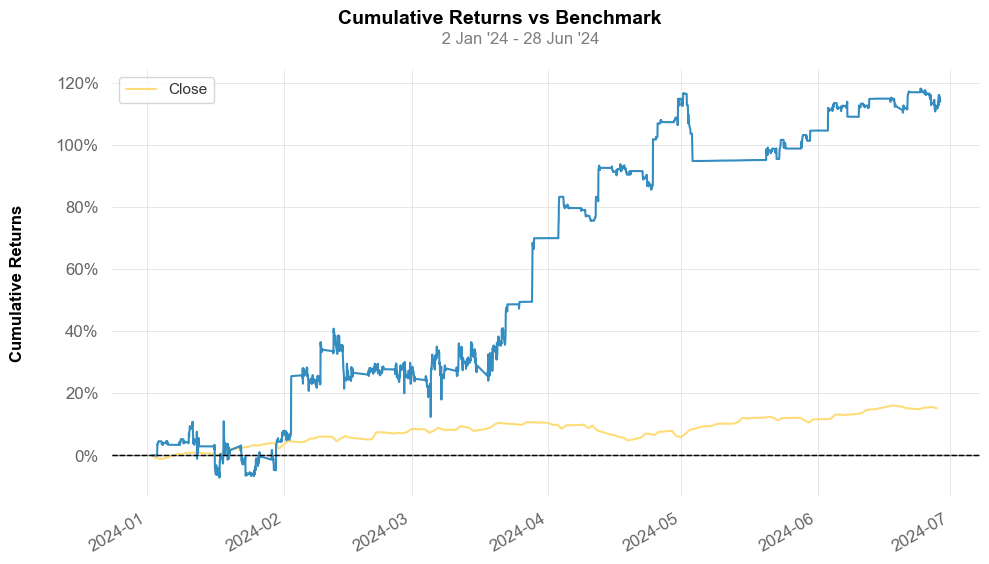

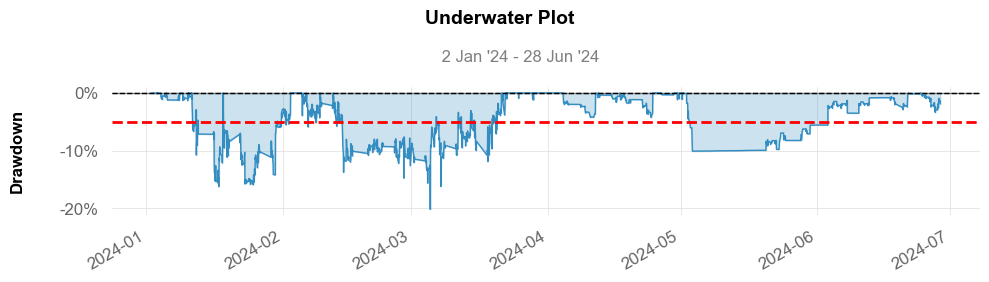

In [32]:
qs.plots.returns(result.returns, benchmark,  fontname='sans-serif')
qs.plots.drawdown(result.returns, figsize=(10,3), fontname='sans-serif')


In [33]:
trades = pd.DataFrame(result.trades)
trades.head(50)

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,GOOG_GOOGL,2024-01-16 04:00:00-05:00,2024-01-16 05:00:00-05:00,-4.309737,-4.335061,-47760,1209.480004,0.587602,19.291400,1.001190e+06
1,AKTS_HYLN,2024-01-10 11:00:00-05:00,2024-01-16 10:00:00-05:00,0.303777,0.393263,-683538,-61166.825705,-29.457630,265.668491,9.397577e+05
2,GOOG_GOOGL,2024-01-17 05:00:00-05:00,2024-01-19 08:00:00-05:00,-4.326535,-3.318497,-43351,-43699.463046,-23.298970,17.503934,8.960407e+05
3,AKTS_HYLN,2024-01-16 10:00:00-05:00,2024-01-23 09:00:00-05:00,0.393263,0.473768,-525020,-42266.880746,-20.471102,199.617239,8.535742e+05
4,GOOG_GOOGL,2024-01-19 08:00:00-05:00,2024-01-25 17:00:00-05:00,-3.318497,-4.904757,-61457,97486.758311,47.800540,24.800564,9.510362e+05
5,PAA_PAGP,2024-01-02 17:00:00-05:00,2024-01-30 07:00:00-05:00,1.634347,1.045104,-122389,72116.868044,36.053721,47.994031,1.023105e+06
6,PAA_PAGP,2024-02-09 08:00:00-05:00,2024-02-09 10:00:00-05:00,0.984560,1.374806,249499,97365.984931,39.636573,97.462753,1.120374e+06
7,AKTS_HYLN,2024-01-25 09:00:00-05:00,2024-02-14 13:00:00-05:00,0.759439,0.933738,-250702,-43697.176228,-22.951071,87.316860,1.076589e+06
8,PAA_PAGP,2024-02-12 07:00:00-05:00,2024-02-15 08:00:00-05:00,2.037863,1.309249,-131317,95679.325222,35.753799,51.307873,1.172217e+06
9,BWA_TPR,2024-02-08 09:00:00-05:00,2024-02-15 09:00:00-05:00,14.659618,17.925310,-16793,-54840.753678,-22.276782,6.300989,1.117370e+06
